# Homework 1. Part 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from scripts.dataset import load_svhn
from scripts.visualise import visualise_dataset
from scripts.knn import KNN
from scripts.metrics import binary_classification_metrics

%load_ext autoreload
%autoreload 2

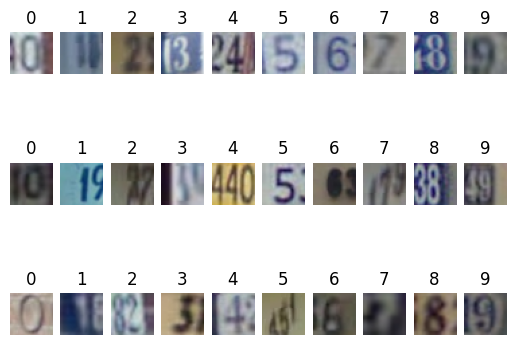

In [2]:
data_folder = Path().cwd() / "data" / "housenumbers"
train_X, train_y, test_X, test_y = load_svhn(data_folder, max_train=1000, max_test=100)
visualise_dataset(train_X, train_y)

# Сначала реализуем KNN для бинарной классификации

В качестве задачи бинарной классификации мы натренируем модель, которая будет отличать цифру 0 от цифры 9.

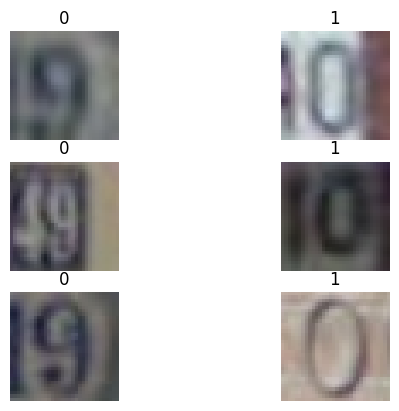

In [3]:
# Only select 0s and 9s
binary_train_mask = (train_y == 0) | (train_y == 9)
binary_train_X = train_X[binary_train_mask]
binary_train_y = train_y[binary_train_mask] == 0

binary_test_mask = (test_y == 0) | (test_y == 9)
binary_test_X = test_X[binary_test_mask]
binary_test_y = test_y[binary_test_mask] == 0

visualise_dataset(binary_train_X, binary_train_y)

# Reshape to 1-dimensional array [num_samples, 32*32*3]
binary_train_X = binary_train_X.reshape(binary_train_X.shape[0], -1)
binary_test_X = binary_test_X.reshape(binary_test_X.shape[0], -1)

## Пришло время написать код! 

Последовательно реализуйте функции `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops`
в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

In [4]:
knn_classifier = KNN(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

dists_two_loop = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists_two_loop[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

dists_one_loop = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists_one_loop[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

dists_no_loop = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists_no_loop[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

assert np.all(dists_two_loop == dists_one_loop)
assert np.all(dists_two_loop == dists_no_loop)

In [5]:
# Lets look at the performance difference
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

10.9 ms ± 439 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.78 ms ± 172 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
22.2 ms ± 3.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


KNN with k = 1
Accuracy: 0.56, Precision: 0.73, Recall: 0.67, F1: 0.70


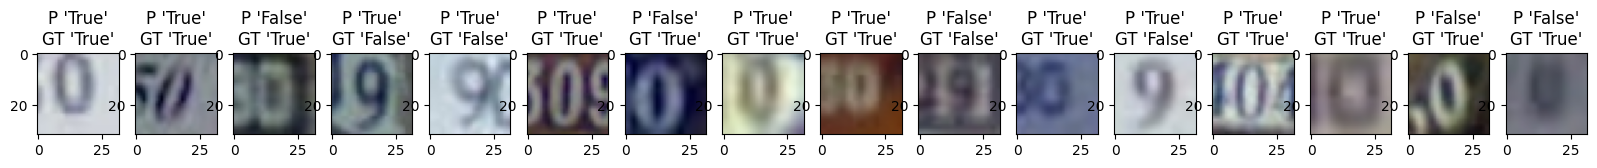

In [8]:
prediction = knn_classifier.predict(binary_test_X)
precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

images = binary_test_X.reshape(binary_test_X.shape[0], 32, 32, 3)
fig, axes = plt.subplots(1, binary_test_X.shape[0], figsize=(20, 20))
for i in range(binary_test_X.shape[0]):
    axes[i].imshow(images[i] / 255)
    axes[i].set_title(f"P '{prediction[i]}'\nGT '{binary_test_y[i]}'")

# Кросс-валидация (cross-validation)

Попробуем найти лучшее значение параметра k для алгоритма KNN! 

Для этого мы воспользуемся k-fold cross-validation (https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation). Мы разделим тренировочные данные на 5 фолдов (folds), и по очереди будем использовать каждый из них в качестве проверочных данных (validation data), а остальные -- в качестве тренировочных (training data).

В качестве финальной оценки эффективности k мы усредним значения F1 score на всех фолдах.
После этого мы просто выберем значение k с лучшим значением метрики.

*Бонус*: есть ли другие варианты агрегировать F1 score по всем фолдам? Напишите плюсы и минусы в клетке ниже.

In [9]:
num_folds = 5
shuffle = list(zip(binary_train_X, binary_train_y))
np.random.shuffle(shuffle)
train_folds_X, train_folds_y = zip(*shuffle)

train_folds_X = np.array(train_folds_X)
train_folds_y = np.array(train_folds_y)

train_folds_X = np.array_split(train_folds_X, num_folds)
train_folds_y = np.array_split(train_folds_y, num_folds)

In [10]:
# Find the best k using cross-validation based on F1 score
k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_f1 = {}  # dict mapping k values to mean F1 scores (int -> float)
k_to_precision = {}
k_to_recall = {}
k_to_accuracy = {}

for k in k_choices:
    knn_classifier = KNN(k)
    # Go through every fold and use it for testing and all other folds for training
    # Perform training and produce F1 score metric on the validation dataset
    # Average F1 from all the folds and write it into k_to_f1
    F_1 = 0
    RECALL = 0
    PRECISION = 0
    ACCURACY = 0
    for i in range(num_folds):
        test_y = train_folds_y[i]
        train_y = train_folds_y[0:i]+train_folds_y[i+1:]

        test_X = train_folds_X[i]
        train_X = train_folds_X[0:i]+train_folds_X[i+1:]

        train_X = np.array([item for sublist in train_X for item in sublist])
        train_y = np.array([item for sublist in train_y for item in sublist])

        knn_classifier.fit(train_X, train_y)
        prediction = knn_classifier.predict(test_X)

        precision, recall, f1, accuracy = binary_classification_metrics(prediction, test_y)

        F_1 += f1
        RECALL += recall
        PRECISION += precision
        ACCURACY += accuracy

    k_to_f1[k] = F_1/num_folds
    k_to_precision[k] = PRECISION/num_folds
    k_to_recall[k] = RECALL/num_folds
    k_to_accuracy[k] = ACCURACY/num_folds


for k in sorted(k_to_f1):
    print(f"k = {k}, f1 = {round(k_to_f1[k], 2)}, acc.= {round(k_to_accuracy[k], 2)}, prec.= {round(k_to_precision[k], 2)}, rec.= {round(k_to_recall[k], 2)}")

k = 1, f1 = 0.63, acc.= 0.55, prec.= 0.57, rec.= 0.71
k = 2, f1 = 0.51, acc.= 0.54, prec.= 0.62, rec.= 0.45
k = 3, f1 = 0.66, acc.= 0.56, prec.= 0.58, rec.= 0.78
k = 5, f1 = 0.62, acc.= 0.51, prec.= 0.54, rec.= 0.76
k = 8, f1 = 0.59, acc.= 0.52, prec.= 0.55, rec.= 0.66
k = 10, f1 = 0.62, acc.= 0.53, prec.= 0.55, rec.= 0.73
k = 15, f1 = 0.65, acc.= 0.52, prec.= 0.53, rec.= 0.84
k = 20, f1 = 0.6, acc.= 0.49, prec.= 0.52, rec.= 0.74
k = 25, f1 = 0.66, acc.= 0.54, prec.= 0.54, rec.= 0.87
k = 50, f1 = 0.51, acc.= 0.38, prec.= 0.45, rec.= 0.63
